In [1]:
import xarray as xr
from dask.dot import dot_graph
import dask.array as da
import numpy as np
import os
from matplotlib import pyplot as plt
%matplotlib inline

import pandas as pd
import xgcm
from xmitgcm import open_mdsdataset
import xrft

In [2]:
import distributed
print(distributed.__version__)
#import blosc
#print(blosc.__version__)
import dask
print(dask.__version__)
print(xr.__version__)

1.16.3+56.g17144fe
0.15.0+6.gd0aa50a
0.9.5-1-gab4ffee


In [4]:
data_dir = '/rigel/ocp/users/db3157/channel_all_res/02km/run_5km_start_tracer'
nsteps = range(4665600, 4665600+103680, (4665744-4665600))
%time ds_tracer_2 = open_mdsdataset(data_dir, delta_t=300, iters= nsteps, prefix=['PTRACER01','T','W','V'], ignore_unknown_vars=True, geometry='cartesian')

/rigel/home/ra2697/xmitgcm/xmitgcm/mds_store.py:696: UserWarning: Couldn't find available_diagnostics.log in /rigel/ocp/users/db3157/channel_all_res/02km/run_5km_start_tracer. Using default version.
  "in %s. Using default version." % data_dir)
/rigel/home/ra2697/xmitgcm/xmitgcm/utils.py:314: UserWarning: Not sure what to do with rlev = L
  warnings.warn("Not sure what to do with rlev = " + rlev)


CPU times: user 37.1 s, sys: 9.99 s, total: 47.1 s
Wall time: 49.3 s


## XArray wraps netCDF Data

In [6]:
ds = ds_tracer_2
ds

<xarray.Dataset>
Dimensions:    (XC: 800, XG: 800, YC: 800, YG: 800, Z: 40, Zl: 40, Zp1: 41, Zu: 40, time: 720)
Coordinates:
  * XG         (XG) >f4 0.0 2500.0 5000.0 7500.0 10000.0 12500.0 15000.0 ...
  * YC         (YC) >f4 1250.0 3750.0 6250.0 8750.0 11250.0 13750.0 16250.0 ...
  * YG         (YG) >f4 0.0 2500.0 5000.0 7500.0 10000.0 12500.0 15000.0 ...
  * XC         (XC) >f4 1250.0 3750.0 6250.0 8750.0 11250.0 13750.0 16250.0 ...
  * Zp1        (Zp1) >f4 0.0 -10.0 -20.0 -30.0 -42.0 -56.0 -72.0 -91.0 ...
  * Z          (Z) >f4 -5.0 -15.0 -25.0 -36.0 -49.0 -64.0 -81.5 -102.0 ...
  * Zl         (Zl) >f4 0.0 -10.0 -20.0 -30.0 -42.0 -56.0 -72.0 -91.0 -113.0 ...
  * Zu         (Zu) >f4 -10.0 -20.0 -30.0 -42.0 -56.0 -72.0 -91.0 -113.0 ...
    rAs        (YG, XC) >f4 6.25e+06 6.25e+06 6.25e+06 6.25e+06 6.25e+06 ...
    dyG        (YC, XG) >f4 2500.0 2500.0 2500.0 2500.0 2500.0 2500.0 2500.0 ...
    dxC        (YC, XG) >f4 2500.0 2500.0 2500.0 2500.0 2500.0 2500.0 2500.0 ...
    rAw       

In [7]:
ds.nbytes / 1e9

295.242265612

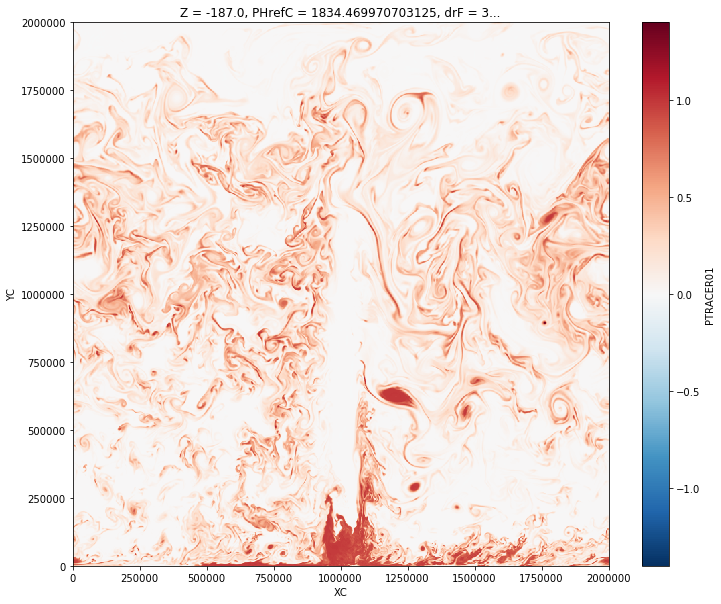

In [8]:
plt.figure(figsize=(12,10))
ds['PTRACER01'].isel(time=100, Z=10).plot()

## Analysis Task: Power Spectrum

Fourier Transform:
$ v(x, t) \to \hat v(k, t) $

Wavenumber Power Spectrum:
$ \langle v^\ast v \rangle (k) $

In [9]:
from dask.distributed import Client

In [20]:
client.restart()

Client Scheduler: tcp://10.43.8.147:8786 Dashboard: http://10.43.8.147:8787,Cluster Workers: 40 Cores: 40 Memory: 431.68 GB


In [19]:
client.shutdown()

In [10]:
#scheduler_file = '../.dask_scheduler/dask_scheduler_file-' + os.environ['SLURM_JOBID']
scheduler_file = '/rigel/home/ra2697/.dask_schedule_file.json'
client = Client(scheduler_file=scheduler_file)
client

Client Scheduler: tcp://10.43.8.147:8786 Dashboard: http://10.43.8.147:8787,Cluster Workers: 60 Cores: 60 Memory: 647.52 GB


In [23]:
# persist dataset, load in to memory
%time dsp = ds.persist()

CPU times: user 3.82 s, sys: 184 ms, total: 4.01 s
Wall time: 3.99 s


In [12]:
dsp.nbytes / 1e9

295.242265612

In [13]:
dsp

<xarray.Dataset>
Dimensions:    (XC: 800, XG: 800, YC: 800, YG: 800, Z: 40, Zl: 40, Zp1: 41, Zu: 40, time: 720)
Coordinates:
  * XG         (XG) >f4 0.0 2500.0 5000.0 7500.0 10000.0 12500.0 15000.0 ...
  * YC         (YC) >f4 1250.0 3750.0 6250.0 8750.0 11250.0 13750.0 16250.0 ...
  * YG         (YG) >f4 0.0 2500.0 5000.0 7500.0 10000.0 12500.0 15000.0 ...
  * XC         (XC) >f4 1250.0 3750.0 6250.0 8750.0 11250.0 13750.0 16250.0 ...
  * Zp1        (Zp1) >f4 0.0 -10.0 -20.0 -30.0 -42.0 -56.0 -72.0 -91.0 ...
  * Z          (Z) >f4 -5.0 -15.0 -25.0 -36.0 -49.0 -64.0 -81.5 -102.0 ...
  * Zl         (Zl) >f4 0.0 -10.0 -20.0 -30.0 -42.0 -56.0 -72.0 -91.0 -113.0 ...
  * Zu         (Zu) >f4 -10.0 -20.0 -30.0 -42.0 -56.0 -72.0 -91.0 -113.0 ...
    rAs        (YG, XC) >f4 6.25e+06 6.25e+06 6.25e+06 6.25e+06 6.25e+06 ...
    dyG        (YC, XG) >f4 2500.0 2500.0 2500.0 2500.0 2500.0 2500.0 2500.0 ...
    dxC        (YC, XG) >f4 2500.0 2500.0 2500.0 2500.0 2500.0 2500.0 2500.0 ...
    rAw       

In [24]:
# just load one slice
ds_slice = dsp.isel(YG=400, YC=400)
ds_slice

<xarray.Dataset>
Dimensions:    (XC: 800, XG: 800, Z: 40, Zl: 40, Zp1: 41, Zu: 40, time: 720)
Coordinates:
  * XG         (XG) >f4 0.0 2500.0 5000.0 7500.0 10000.0 12500.0 15000.0 ...
    YC         >f4 1.00125e+06
    YG         >f4 1e+06
  * XC         (XC) >f4 1250.0 3750.0 6250.0 8750.0 11250.0 13750.0 16250.0 ...
  * Zp1        (Zp1) >f4 0.0 -10.0 -20.0 -30.0 -42.0 -56.0 -72.0 -91.0 ...
  * Z          (Z) >f4 -5.0 -15.0 -25.0 -36.0 -49.0 -64.0 -81.5 -102.0 ...
  * Zl         (Zl) >f4 0.0 -10.0 -20.0 -30.0 -42.0 -56.0 -72.0 -91.0 -113.0 ...
  * Zu         (Zu) >f4 -10.0 -20.0 -30.0 -42.0 -56.0 -72.0 -91.0 -113.0 ...
    rAs        (XC) >f4 6.25e+06 6.25e+06 6.25e+06 6.25e+06 6.25e+06 ...
    dyG        (XG) >f4 2500.0 2500.0 2500.0 2500.0 2500.0 2500.0 2500.0 ...
    dxC        (XG) >f4 2500.0 2500.0 2500.0 2500.0 2500.0 2500.0 2500.0 ...
    rAw        (XG) >f4 6.25e+06 6.25e+06 6.25e+06 6.25e+06 6.25e+06 ...
    rA         (XC) >f4 6.25e+06 6.25e+06 6.25e+06 6.25e+06 6.25e+06 ...

In [43]:
ds_slice = ds_slice.load()
# hack the dimensions
ds_slice.W.variable.dims = ['time', 'Z', 'XC']
ds_slice.V.variable.dims = ['time', 'Z', 'XC']
ds_slice

<xarray.Dataset>
Dimensions:    (XC: 800, XG: 800, Z: 40, Zl: 40, Zp1: 41, Zu: 40, time: 720)
Coordinates:
  * XG         (XG) >f4 0.0 2500.0 5000.0 7500.0 10000.0 12500.0 15000.0 ...
    YC         >f4 1.00125e+06
    YG         >f4 1e+06
  * XC         (XC) >f4 1250.0 3750.0 6250.0 8750.0 11250.0 13750.0 16250.0 ...
  * Zp1        (Zp1) >f4 0.0 -10.0 -20.0 -30.0 -42.0 -56.0 -72.0 -91.0 ...
  * Z          (Z) >f4 -5.0 -15.0 -25.0 -36.0 -49.0 -64.0 -81.5 -102.0 ...
  * Zl         (Zl) >f4 0.0 -10.0 -20.0 -30.0 -42.0 -56.0 -72.0 -91.0 -113.0 ...
  * Zu         (Zu) >f4 -10.0 -20.0 -30.0 -42.0 -56.0 -72.0 -91.0 -113.0 ...
    rAs        (XC) float32 6.25e+06 6.25e+06 6.25e+06 6.25e+06 6.25e+06 ...
    dyG        (XG) float32 2500.0 2500.0 2500.0 2500.0 2500.0 2500.0 2500.0 ...
    dxC        (XG) float32 2500.0 2500.0 2500.0 2500.0 2500.0 2500.0 2500.0 ...
    rAw        (XG) float32 6.25e+06 6.25e+06 6.25e+06 6.25e+06 6.25e+06 ...
    rA         (XC) float32 6.25e+06 6.25e+06 6.25e+06 6

In [64]:
ds_slice['PTRACER01_anom'] = ds_slice.PTRACER01 - ds_slice.PTRACER01.mean(dim='XC')

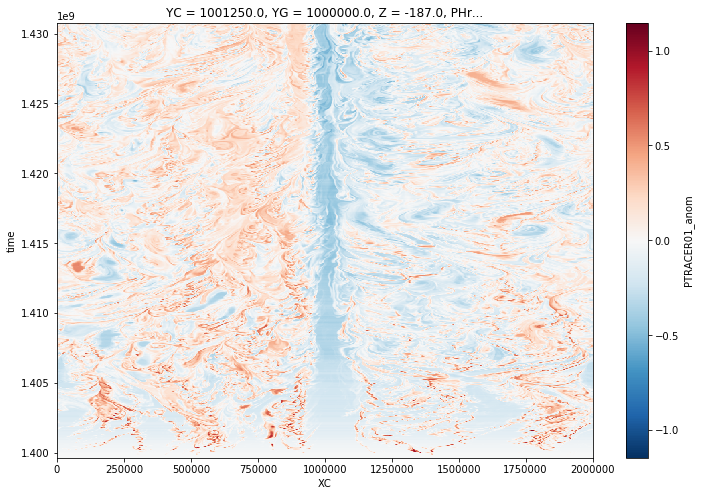

In [65]:
plt.figure(figsize=(12,8))
ds_slice.PTRACER01_anom.isel(Z=10).plot()

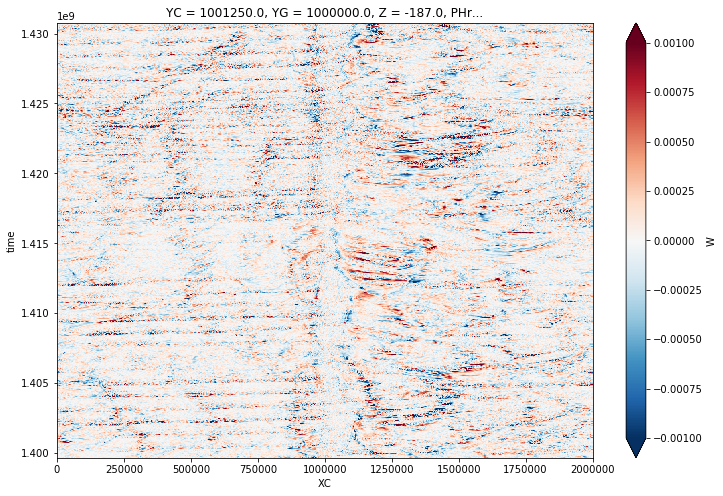

In [45]:
plt.figure(figsize=(12,8))
ds_slice.W.isel(Z=10).plot(vmax=1e-3)

In [35]:
import xrft

In [46]:
W_ps = xrft.power_spectrum(ds_slice.W, dim=['XC', 'time'])
W_ps

<xarray.DataArray (freq_time: 720, Z: 40, freq_XC: 800)>
array([[[  1.597193e-07,   1.566504e-07, ...,   2.690574e-07,   1.566504e-07],
        [  3.480103e-02,   3.388980e-02, ...,   1.723717e-03,   3.388980e-02],
        ..., 
        [  2.546528e-03,   1.900702e-02, ...,   1.351876e-02,   1.900702e-02],
        [  1.436053e-04,   5.932740e-03, ...,   3.524312e-03,   5.932740e-03]],

       [[  2.559711e-07,   2.982077e-07, ...,   3.382861e-07,   2.639895e-07],
        [  1.915007e-02,   2.475241e-03, ...,   1.490203e-02,   3.140565e-02],
        ..., 
        [  3.485210e-02,   1.480929e-03, ...,   5.224997e-02,   5.578846e-02],
        [  3.933024e-03,   1.121686e-04, ...,   9.352087e-03,   6.654979e-03]],

       ..., 
       [[  1.900478e-07,   2.080571e-08, ...,   3.915111e-07,   3.435586e-07],
        [  4.721026e-02,   4.903051e-02, ...,   1.886187e-01,   4.540296e-02],
        ..., 
        [  1.795001e-02,   4.464542e-02, ...,   9.077546e-03,   1.089620e-02],
        [  4.45

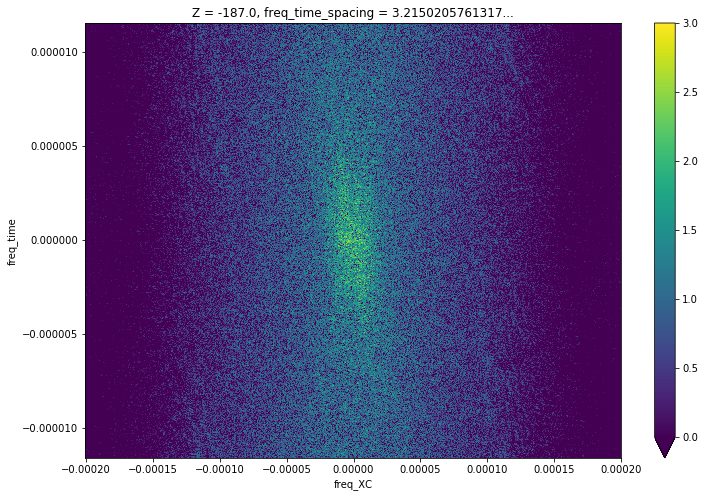

In [47]:
plt.figure(figsize=(12,8))
np.log10(W_ps.isel(Z=10)).plot(vmin=0, vmax=3)

In [66]:
wtr_cs = xrft.cross_spectrum(ds_slice.W, ds_slice.PTRACER01_anom, dim=['XC', 'time'])

In [67]:
# smooth it
wtr_cs_sm = xr.DataArray(
                gaussian_filter(wtr_cs, 2.0),
                coords=wtr_cs.coords, dims=wtr_cs.dims)

In [68]:
from matplotlib.colors import LogNorm, SymLogNorm
from scipy.ndimage.filters import gaussian_filter

In [81]:
month = (24*60*60*31)**-1
km100 = (100e3)**-1

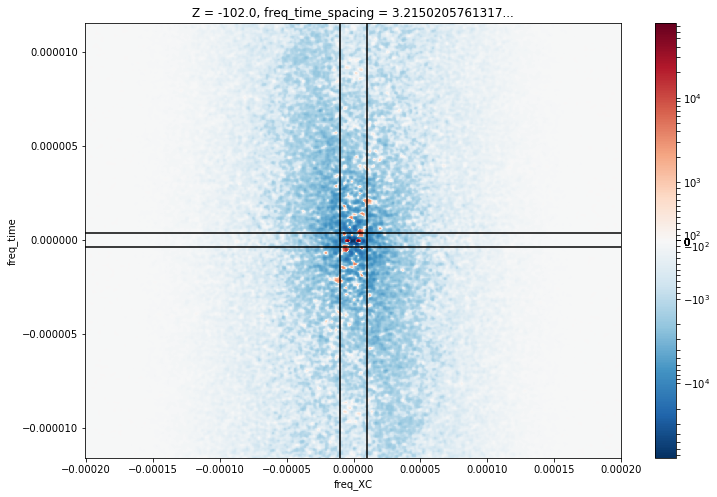

In [92]:
fig, ax = plt.subplots(figsize=(12,8))
wtr_cs_sm.isel(Z=7).plot(norm=SymLogNorm(1000), ax=ax)
ax.axhline(month, color='k')
ax.axhline(-month, color='k')
ax.axvline(km100, color='k')
ax.axvline(-km100, color='k')
#ax.set_yscale('symlog', linthreshy=month/12)
#ax.set_xscale('symlog', linthreshx=km100/10)

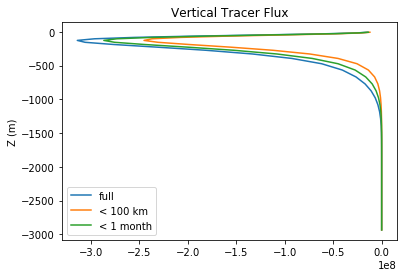

In [103]:
z = wtr_cs_sm.Z
plt.plot(wtr_cs_sm.sum(dim=['freq_XC', 'freq_time']), z, label='full')
plt.plot(wtr_cs_sm.where(abs(wtr_cs_sm.freq_XC)>km100).sum(dim=['freq_XC', 'freq_time']), z, label='< 100 km')
plt.plot(wtr_cs_sm.where(abs(wtr_cs_sm.freq_time)>month).sum(dim=['freq_XC', 'freq_time']), z, label='< 1 month')
plt.legend()
plt.ylabel('Z (m)')
plt.title('Vertical Tracer Flux')

/rigel/home/ra2697/miniconda/envs/dask_distributed/lib/python3.5/site-packages/matplotlib/colors.py:1029: RuntimeWarning: invalid value encountered in greater
  masked = np.abs(a) > self.linthresh


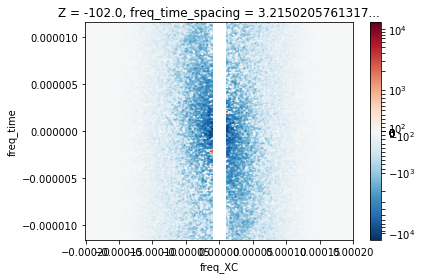

In [96]:
wtr_cs_sm.isel(Z=7).where(abs(wtr_cs_sm.freq_XC)>km100).plot(norm=SymLogNorm(1000))